In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS, WLS
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import gridspec

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# get all of the filenames
path = os.getcwd()+'/Data'
os.chdir(path)
filenames = os.listdir(path)
filenames = filenames[1:]
filenames.sort()

In [3]:
# factors
style_factors = ['BETA','MOMENTUM','SIZE','VOL']
alpha_factors = ['tir','td']

apt20071031 = pd.read_csv('apt.2017-10-31.txt', sep="|")
industry_factors = list(set(apt20071031['GICCODE']))

In [4]:
Trade_Dates = map(lambda x: x.split(".")[1], filenames)

In [478]:
import warnings
warnings.filterwarnings('ignore')

# Problem 1

### (a) Compute OLS factor returns and weighted-least-squares (WLS) versions

OLS

In [5]:
def OLS_factor_return(X,R):
    
    ### INPUT ###
    # X: matrix, risk factors, e.g. market beta, size, volatility, momentum, value, industry...
    # R: matrix, return in excess of risk-free rate
    
    ### OUTPUT ###
    # matrix, OLS factor return
    
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), R)

In [480]:
f_matrix_OLS = pd.DataFrame(index = Trade_Dates,columns = style_factors + alpha_factors +industry_factors)
Sigma2 = pd.DataFrame()

for filename in filenames:
    
    data = pd.read_csv(filename, sep='|',index_col=0)
    data = data.dropna()
    date = filename.split('.')[1]
    
    # risk factor matrix 
    X = data[style_factors+alpha_factors]
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)  
            
    # return matrix
    R = data['R']
    
    # calculate factor return
    f = list(OLS_factor_return(X, R))
    f_matrix_raw = pd.DataFrame(f,columns=[date])
    index_column = []
    for factor in style_factors+alpha_factors+industry_factors:
        try:
            index = list(X.columns).index(factor)
        except ValueError: # there is no such industry
            continue
        index_column.append(factor)
        f_matrix_OLS.loc[date,factor] = f[index]
    f_matrix_raw.index = index_column
    
    # calculate residuals
    #Industry_matrix = data['GICCODE']
    #residual = (np.dot(X,f_matrix_raw) - data["R"].values)**2
    #residual = (data.loc[X.index,'R'] -  np.dot(X,f_matrix_raw[date]))**2
    #residual.name = date
    #Sigma2 = pd.concat([Sigma2,residual],axis = 1)

In [11]:
sig2bar = Sigma2.mean(axis = 1)
f_ols = f_matrix_OLS.mean(axis = 0)

WLS

In [14]:
def WLS_factor_return(X,R,Wt):
    
    ### INPUT ###
    # X: matrix, risk factors, e.g. market beta, size, volatility, momentum, value, industry...
    # R: matrix, return in excess of risk-free rate
    
    ### OUTPUT ###
    # matrix, OLS factor return
    
    return np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(X.T,Wt),X)),X.T),Wt),R)

In [481]:
f_matrix_WLS = pd.DataFrame(index=Trade_Dates,columns = style_factors + alpha_factors +industry_factors)
WLS_Sigma2 = pd.DataFrame()

for filename in filenames:
    
    data = pd.read_csv(filename, sep='|',index_col=0)
    data = data.dropna()
    date = filename.split('.')[1]
        
    # risk factor matrix
    X = data[style_factors+alpha_factors]
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)
    
    # outlier trimming
    trim = 0.1
    Wt = data.loc[X.index,'RESVOL']
    TrimmingValue = Wt.quantile(trim)
    Wt[Wt.rank()<((Wt.size)*trim)] = TrimmingValue
    Wt = np.diag(1/(Wt**2))
    
    # return matrix
    R = data.loc[X.index,'R']
    
    # calculate factor return
    f = list(WLS_factor_return(X, R, Wt))
    f_matrix_raw = pd.DataFrame(f,columns=[date])
    index_column = []
    for factor in style_factors+alpha_factors+industry_factors:
        try:
            index = list(X.columns).index(factor)
        except ValueError: # there is no such industry
            continue
        index_column.append(factor)
        f_matrix_WLS.loc[date,factor] = f[index]
    f_matrix_raw.index = index_column
    

    #residual = (data.loc[X.index,"R"] -  np.dot(X,f_matrix_raw[date]))**2
    #residual.name = date
    #WLS_Sigma2 = pd.concat([WLS_Sigma2,residual],axis = 1)

In [16]:
f_matrix_OLS.to_csv('OLS_F.csv')
Sigma2.to_csv('OLS_sigma2.csv')
f_matrix_WLS.to_csv('WLS_F.csv')
WLS_Sigma2.to_csv('WLS_sigma2.csv')

### (b) For each of the alpha factors, plot the cumulative-sum time series of the corresponding element of f with both methods (OLS and WLS)

In [34]:
f_matrix_OLS.index = pd.to_datetime(f_matrix_OLS.index)
f_matrix_WLS.index = pd.to_datetime(f_matrix_WLS.index)

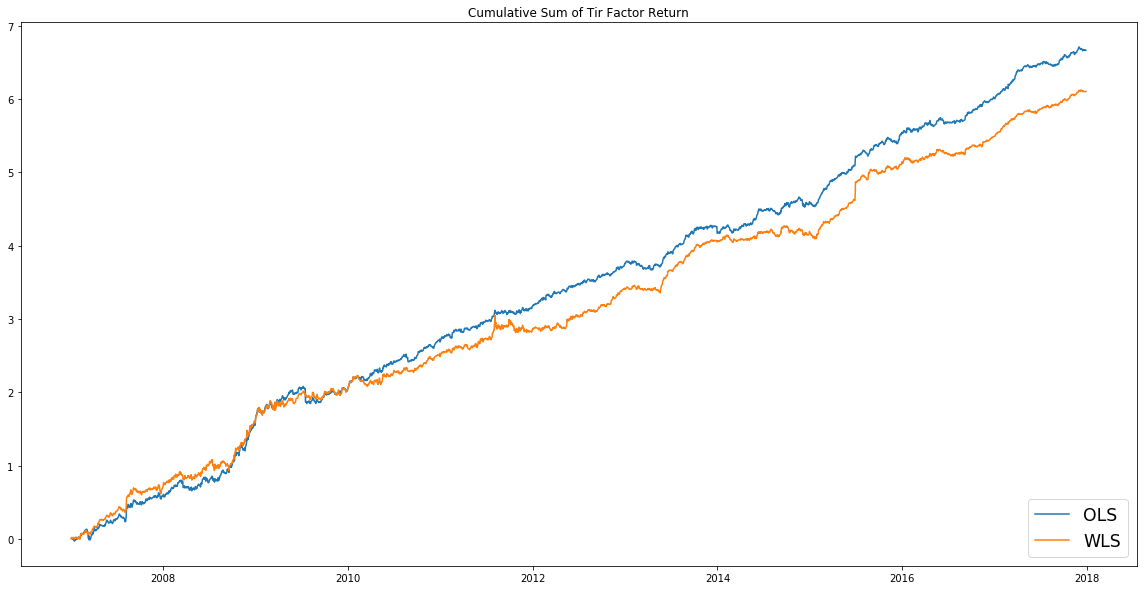

In [35]:
plt.figure(figsize=(20,10))
l1, = plt.plot(f_matrix_OLS['tir'].cumsum())
l2, = plt.plot(f_matrix_WLS['tir'].cumsum())
plt.legend(handles=[l1,l2,], labels=['OLS','WLS'], loc='lower right',fontsize='xx-large') 
plt.title('Cumulative Sum of Tir Factor Return')
plt.show()

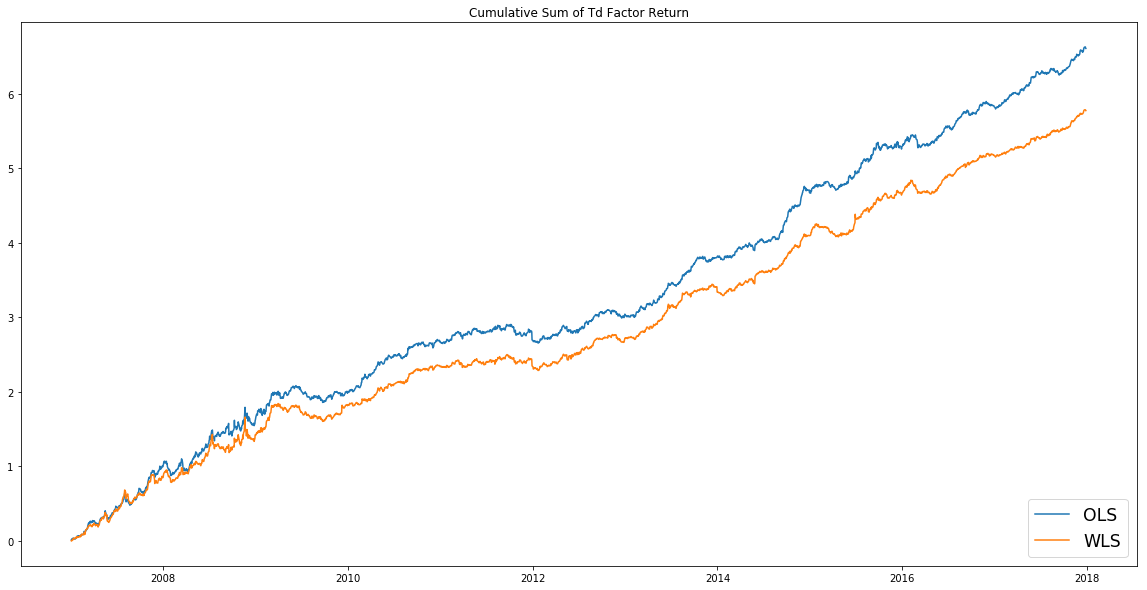

In [36]:
plt.figure(figsize=(20,10))
l1, = plt.plot(f_matrix_OLS['td'].cumsum())
l2, = plt.plot(f_matrix_WLS['td'].cumsum())
plt.legend(handles=[l1,l2,], labels=['OLS','WLS'], loc='lower right',fontsize='xx-large') 
plt.title('Cumulative Sum of Td Factor Return')
plt.show()

In [25]:
import scipy

_,pvalue_tir = scipy.stats.ttest_ind(f_matrix_OLS['tir'],f_matrix_WLS['tir'])
_,pvalue_td = scipy.stats.ttest_ind(f_matrix_OLS['td'],f_matrix_WLS['td'])
print ('The p-value of t-test between OLS tir and WLS tir is: '+str(pvalue_tir))
print ('The p-value of t-test between OLS td and WLS td is: '+str(pvalue_td))

The p-value of t-test between OLS tir and WLS tir is: 0.6177327807305777
The p-value of t-test between OLS td and WLS td is: 0.4516719363188564


Conclusion: They are not significantly different.
The result depends on the trim I use. If the trim I use is bigger, the result may be that they are different.

### (c) Estimate the mean factor returns by the sample mean of the OLS and WLS estimates

In [26]:
print ('Mean of tir in OLS is:'+ str(f_matrix_OLS['tir'].mean()))
print ('Mean of td in OLS is:'+ str(f_matrix_OLS['td'].mean()))
print ('Mean of tir in WLS is:'+ str(f_matrix_WLS['tir'].mean()))
print ('Mean of td in WLS is:'+ str(f_matrix_WLS['td'].mean()))

Mean of tir in OLS is:0.0024080505972778835
Mean of td in OLS is:0.002387566187665852
Mean of tir in WLS is:0.002205770188237306
Mean of td in WLS is:0.002086028165185332


# Problem 2

### (a) Write a function that can compute h* without ever forming an n x n matrix in computer memory

In [185]:
def cal_hstar(X,F,D,alpha,kappa):
    X_inv = np.linalg.pinv(X)
    D_inv = np.linalg.inv(D)
    D_invsqrt = D_inv**(0.5)
    mu_f = np.dot(np.linalg.pinv(X),alpha)
    return (1/kappa)*np.dot(np.dot(np.dot(D_invsqrt,np.linalg.pinv(np.dot(X.T,D_invsqrt))),
                               np.linalg.pinv(F + np.linalg.pinv(np.dot(np.dot(X.T,D_inv),X)))),mu_f)

### (b) Find k so that, with constant k, the average gross market value (GMV = long + short) of h* is 500 million USD.

In [479]:
k = 1.
kappa_sum = 0

for filename in filenames[1:]: # do not contain the first day
    data = pd.read_csv(filename, sep='|', index_col=0)
    data = data.dropna()
    date = filename.split('.')[1]
    
    X = data[style_factors+alpha_factors]
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)
    X = X.dropna()
    
    alpha = X['td']+X['tir']
    
    #index = filenames.index(filename)
    F = f_matrix_OLS.loc[:date,X.columns].astype(float).cov().values
    
    D = np.diag(data.loc[X.index,'RESVOL']**2)
    
    H_Star = cal_hstar(X,F,D,alpha,k)
    kappa_sum += abs(H_Star).sum() / 500000000

kappa_best = kappa_sum/len(filenames[1:])

In [202]:
print ('The best kappa is:' + str(kappa_best))

The kappa is:0.00013804577063235944


### (c) With this choice of k, using the Markowitz-optimization function you wrote previously, plot the time-series of cumulative P/L before costs

### (d) Plot costs

In [477]:
# (c) and (d) together

PNL_list = []
cost_list = []


for filename in filenames[1:]: # do not contain the first day
    data = pd.read_csv(filename, sep='|', index_col=0)
    data = data.dropna()
    date = filename.split('.')[1]
    
    X = data[style_factors+alpha_factors]
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)
    X = X.dropna()
    
    alpha = X['td']+X['tir']
    
    #index = filenames.index(filename)
    F = f_matrix_OLS.loc[:date,X.columns].astype(float).cov().values
    
    D = np.diag(data.loc[X.index,'RESVOL']**2)
    
    H_Star = cal_hstar(X,F,D,alpha,kappa_best)
    PNL_list.append(np.dot(H_Star.T, data.loc[X.index,'R'].values))
    
    daily_ADVP = data.loc[X.index,'ADVP'].values
    cost = (H_Star**2)*0.1/daily_ADVP
    cost_list.append(cost.sum())

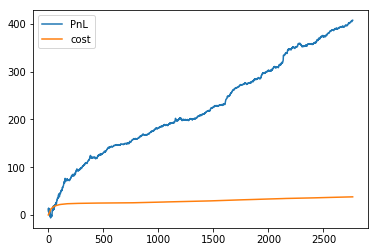

In [208]:
#plot cumulative PnL and cost
plt.plot(np.cumsum(PNL_list),label='PnL')
plt.plot(np.cumsum(cost_list),label='cost')
plt.legend()
plt.show()

### (e) Compute and plot (as daily time series) the percent of the variance in these portfolios due to alpha factors, non-alpha factors, and idiosyncratic (non-factor) variance

In [476]:
idio_var_pct = []
alpha_var_pct = []
hT_sigma_h = []
hT_D_h = []
x_tir_var = []
x_td_var = []


for filename in filenames[1:]:
    data = pd.read_csv(filename, sep='|', index_col=0)
    data = data.dropna()
    date = filename.split('.')[1]
    
    X = data[style_factors+alpha_factors]
    #X = X.dropna()
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)
    
    alpha = X['td']+X['tir']
    
    #index = filenames.index(filename)
    F = f_matrix_OLS.loc[:date,X.columns].astype(float).cov().values
    
    D = np.diag(data.loc[X.index,'RESVOL']**2)
    
    Sigma = np.dot(np.dot(X,F),X.T) + D
    H_Star = cal_hstar(X,F,D,alpha,kappa)
    x = np.dot(X.T,H_Star)
    
    hT_sigma_h.append(np.dot(np.dot(H_Star.T,Sigma),H_Star))
    hT_D_h.append(np.dot(np.dot(H_Star.T,D),H_Star))
    
    x_tir = x[4]
    x_tir_var.append(x_tir*np.dot(F[4,:],x))
    
    x_td = x[5]
    x_td_var.append(x_td*np.dot(F[5,:],x))

In [221]:
alpha_var_pct = (np.array(x_tir_var) + np.array(x_td_var))/np.array(hT_sigma_h)
idio_var_pct = np.array(hT_D_h)/np.array(hT_sigma_h)
nonalpha_var_pct = 1 - idio_var_pct - alpha_var_pct

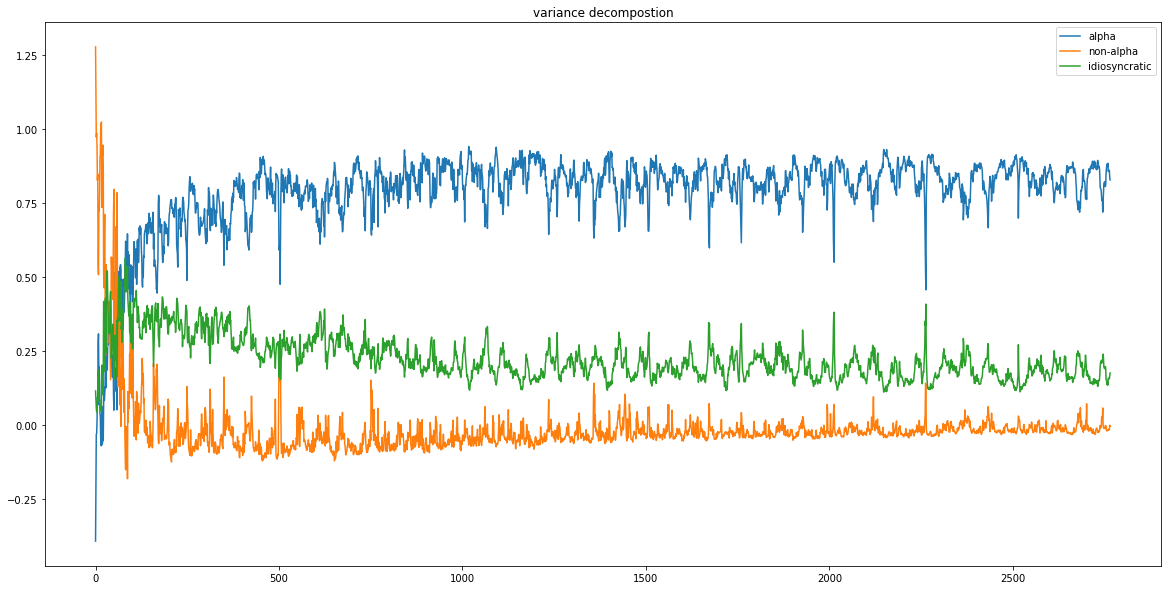

In [218]:
plt.figure(figsize=(20,10))
plt.plot(alpha_var_pct,label='alpha')
plt.plot(nonalpha_var_pct,label='non-alpha')
plt.plot(idio_var_pct,label='idiosyncratic')
plt.legend(loc='best')
plt.title('Variance Decompostion')
plt.show()

# Problem 3

### (a) Write a function which computes the Black-Litterman portfolio

In [239]:
# Black-Litterman calculation function
def computeBlackLitterman(kappa,q0,tau,heq,X,F,D,omega,P):
    Sigma = np.dot(np.dot(X,F),X.T)+D
    Pi = kappa*(1+tau)*np.dot(Sigma,heq)
    C = tau*Sigma
    C_inv = np.linalg.inv(C)
    H = np.dot(P.T,P)/omega + C_inv
    H_inv = np.linalg.inv(H)
    h_BL = 1/kappa * np.dot(np.dot(np.linalg.inv(H_inv+Sigma),H_inv),((P.T/omega*q0).reshape(-1)+np.dot(C_inv,Pi)))
    return h_BL

### (b) Show, on the same graph, the cumulative returns of hB and the cumulative returns of the Black-Litterman portfolio

In [475]:
tau = 0.01
kappa = 1.0
omega = 0.04
q0 = 0.05

heq_return = []
heq_scale_return = []
heq_absscale_return = []
h_BL_return = []
h_BL_scale_return = []
h_BL_absscale_return = []

for filename in filenames:
    data = pd.read_csv(filename, sep='|', index_col=0)
    date = filename.split('.')[1]
    
    X = data[style_factors+alpha_factors]
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    X = X.convert_objects(convert_numeric=True)
    X = X.dropna()
    
    alpha = X['td']+X['tir']
    P = alpha.reshape(1,-1)
    
    #index = filenames.index(filename)
    F = f_matrix_OLS.loc[:date,X.columns].astype(float).cov().values
    
    D = np.diag(data.loc[X.index,'RESVOL']**2)
    
    heq = data.loc[X.index,'USDCAP']
    #heq = heq/heq.sum()
    heq_scale = heq/heq.sum()
    heq_absscale = heq/abs(heq).sum()
    
    h_BL = computeBlackLitterman(kappa,q0,tau,heq,X,F,D,omega,P)
    h_BL_scale = h_BL/h_BL.sum()
    h_BL_absscale = h_BL/abs(h_BL).sum()
    
    R = data.loc[X.index,"R"]
    heq_return.append(np.dot(heq,R))
    heq_scale_return.append(np.dot(heq_scale,R))
    heq_absscale_return.append(np.dot(heq_absscale,R))
    h_BL_return.append(np.dot(h_BL,R))
    h_BL_scale_return.append(np.dot(h_BL_scale,R))
    h_BL_absscale_return.append(np.dot(h_BL_absscale,R))

I plot three different graphs of the pure return of benchmark vs Black-Litterman, the scaled return and the scaled return with absolute holdings

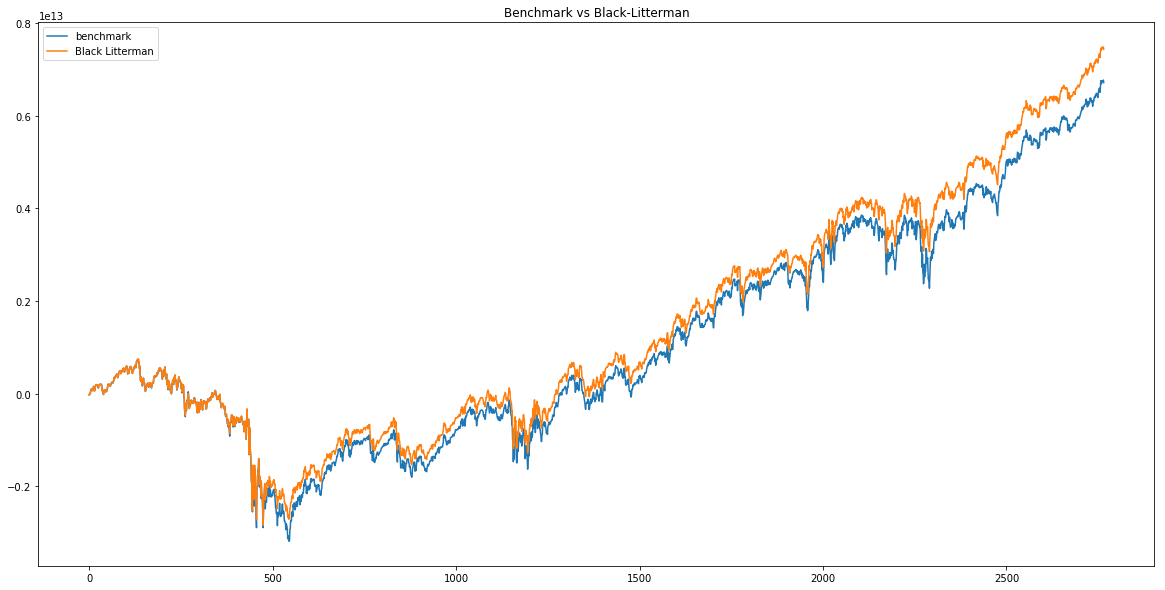

In [250]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(heq_return[1:]),label='benchmark')
plt.plot(np.cumsum(h_BL_return[1:]),label='Black Litterman')
plt.legend()
plt.title('Benchmark vs Black-Litterman')
plt.show()

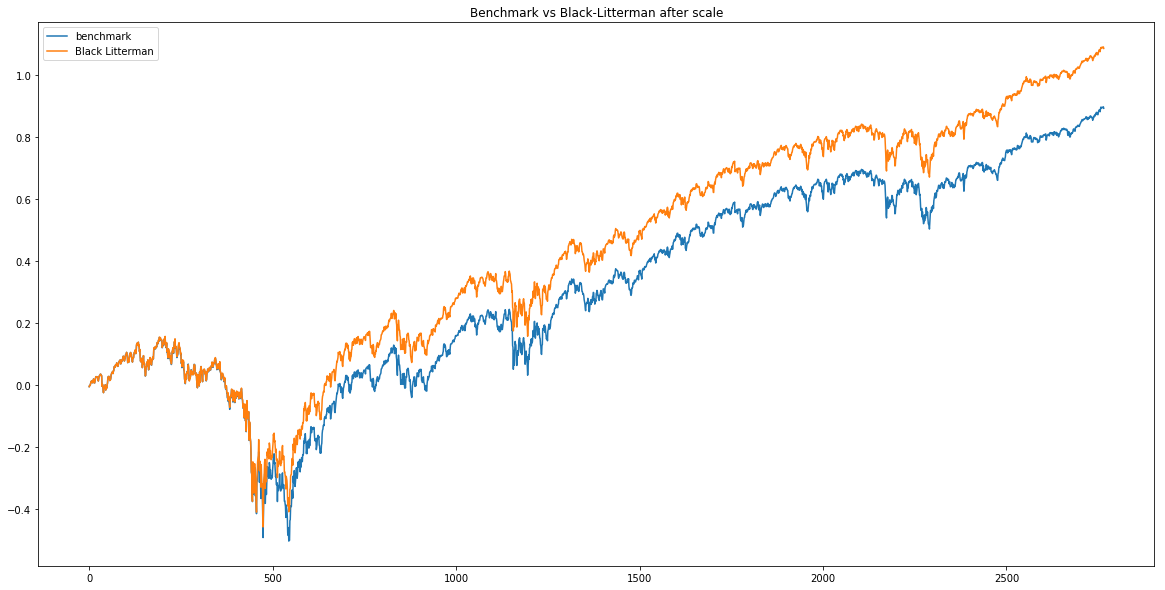

In [252]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(heq_scale_return[1:]),label='benchmark')
plt.plot(np.cumsum(h_BL_scale_return[1:]),label='Black Litterman')
plt.legend()
plt.title('Benchmark vs Black-Litterman after scale')
plt.show()

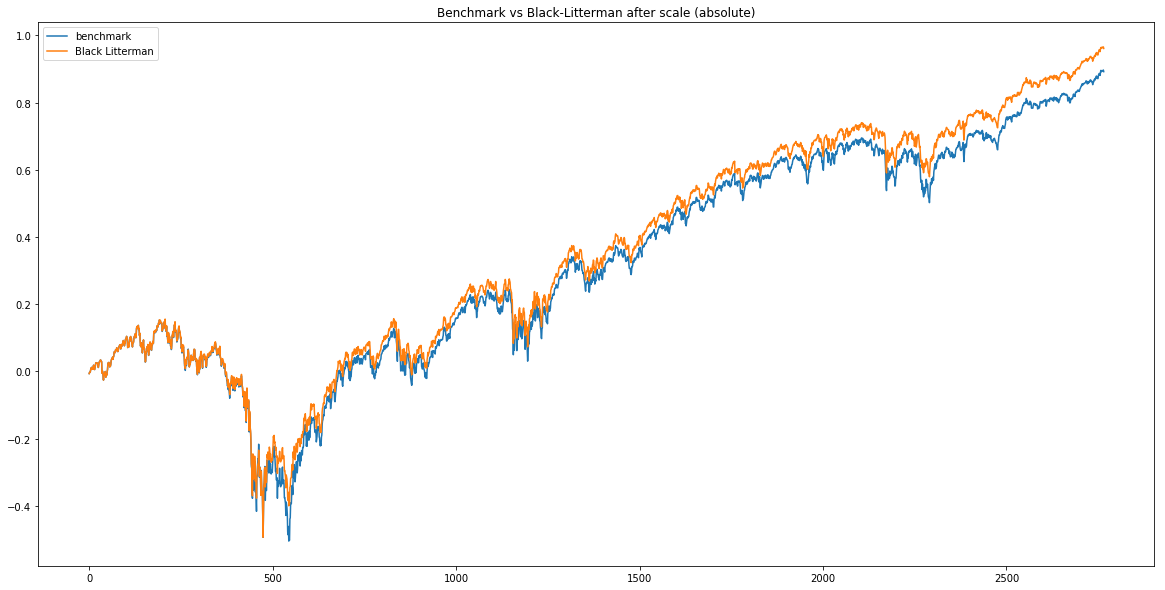

In [253]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(heq_absscale_return[1:]),label='benchmark')
plt.plot(np.cumsum(h_BL_absscale_return[1:]),label='Black Litterman')
plt.legend()
plt.title('Benchmark vs Black-Litterman after scale (absolute)')
plt.show()

# Problem 4

### (a) Estimate the parameters of the factor-return process using a linear mixed-effects (LME) model

In [318]:
from scipy.stats import norm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy import optimize
from cvxopt import solvers, matrix

In [437]:
#LME_Fmatrix = pd.DataFrame(0, index=Trade_Dates, columns=style_factors + alpha_factors +industry_factors) 
LME_Hmatrix =  pd.DataFrame() 
LME_PNLmatrix =  pd.DataFrame() 

In [474]:
for filename in filenames[:-4]:
    data = pd.read_csv(filename,sep ="|",index_col=0)
    date = filename.split(".")[1]

    X = data[style_factors+alpha_factors]
    X = X.dropna()
    for industry in industry_factors:
        X[industry] = (data['GICCODE']==industry)*1 # convert bool to int 0,1
    X = X.loc[:, (X != 0).any(axis=0)]
    #X_delete = X[6:].loc[(X[6:]!=0).any(axis=1),:]
    #X = X.loc[X_delete.index,:]
    X = X.convert_objects(convert_numeric=True)
    #X = X.T.drop_duplicates().T
    
    Xt = X.as_matrix()
    Xt = Xt.astype(float)    
    rt = data.loc[X.index,'R'].values
    rt = rt.astype(float)
    groups = np.kron(np.arange(len(rt)),1)
    model = MixedLM(rt,Xt,groups)
    lmeresult = model.fit(full_output = True)
    # resultset.summary()    
    beta = lmeresult.fe_params
    alphabeta = lmeresult.fe_params[[4,5]]
    
    
#     for factor in style_factors+alpha_factors+industry_factors:
#         try:
#             index = list(X.columns).index(factor)
#         except ValueError: # there is no such industry
#             continue
#         #index_column.append(factor)
#         LME_Fmatrix.loc[date,factor] = beta[index]
        
        
    #LME_Fmatrix[date] = beta
    corr = lmeresult.normalized_cov_params[:,:-1][:-1]        
    fbeta = f_matrix_OLS.loc[date,alpha_factors]
    alpha = np.dot(X[alpha_factors].as_matrix().astype(float), alphabeta)
    D = np.diag(data.loc[X.index,'RESVOL']**2)
    Sigma = pd.DataFrame(np.dot(np.dot(X,corr),X.T)+D, index=X.index, columns=X.index)
    if len(Sigma.dropna())>0:
        Sigma = Sigma.fillna(0)
        R = data.loc[X.index,"R"]
        hk = pd.Series(np.dot(np.linalg.inv(Sigma),alpha),index=X.index,name=date)
        LME_Hmatrix = pd.concat([LME_Hmatrix,hk],axis = 1)
        LME_PNLmatrix = pd.concat([LME_PNLmatrix, pd.Series(hk*R,name=date)],axis=1)

### (b) Are your estimates for beta for the alpha factors different from the estimates f derived previously?

In [439]:
_,pvalue_tir2 = scipy.stats.ttest_ind(f_matrix_OLS['tir'],LME_Fmatrix['tir'])
_,pvalue_td2 = scipy.stats.ttest_ind(f_matrix_OLS['td'],LME_Fmatrix['td'])
print ('The p-value of t-test between OLS tir and LME tir is: '+str(pvalue_tir2))
print ('The p-value of t-test between OLS td and LME td is: '+str(pvalue_td2))

The p-value of t-test between OLS tir and LME tir is: 0.9879858089599841
The p-value of t-test between OLS td and LME td is: 0.9882714324396515


The p-value is greater than 0.05, we cannot reject the null hypothesis. They are not different

### (c) Plot LME and Markowitz

In [468]:
LME_PNL = LME_PNLmatrix.sum(axis=0).cumsum() * kappa_best
LME_PNL.index = pd.to_datetime(LME_PNL.index)

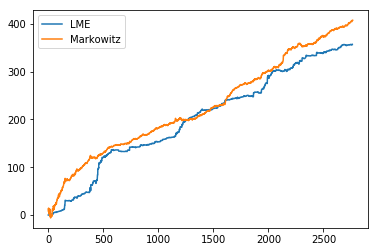

In [471]:
plt.plot(LME_PNL.values,label='LME')
plt.plot(np.cumsum(PNL_list),label='Markowitz')
plt.legend()
plt.show()

# Problem 5

In [255]:
# dx_t = -lambda*x_t  + sigma*ep_t, x_t = log(pt/pe)
H = 5
lmbd = np.log(2)/H
sigma = 0.1
pe = 50

In [256]:
N = 100000
eps_list = np.random.normal(0,1,N)
xt = np.zeros(N)
for i in range(1,N):
    xt[i] = min((1-lmbd)*xt[i-1] + sigma*eps_list[i],np.log(2))
pt = list(map(lambda x: round(x,1), np.exp(np.array(xt))*pe))

In [257]:
# Action Space
K = 5
Lotsize = 100.0
fA = np.array(range(-K, K+1))*Lotsize

In [258]:
# Holding Amount
M = 10
fH = np.array(range(-M, M+1))*Lotsize
Hmin = fH.min()
Hmax = fH.max()

In [259]:
# Possible Price
TickSize = 0.1
fP = np.array(range(1,1001))*TickSize 

In [260]:
# Cost
def SpreadCost(dn, TickSize):
    return TickSize*np.abs(dn)

def ImpactCost(dn, TickSize, Lotsize):
    return dn**2*TickSize/Lotsize
    
def Cost(dn, TickSize, Lotsize):
    return SpreadCost(dn,TickSize) + ImpactCost(dn,TickSize, Lotsize)

In [261]:
kappa = 1e-4
gamma = 0.999
alpha = 0.001
eps = 0.1

In [313]:
def Rt(dvt, kappa):
    return dvt - 0.5*kappa*(dvt**2)
     
def sharpe_ratio(R):
    return (252*np.mean(R))/(np.sqrt(252)*np.var(R))

def PNL(pt, Nt, TickSize, Lotsize, i):
    return  -(Nt[i]*(pt[i+1]-pt[i]) - Cost((Nt[i]-Nt[i-1]), TickSize, Lotsize))

def amount_trade(pt, Nt, i): # calculate the volume/amount that trades
    return abs((Nt[i]-Nt[i-1])*pt[i])

In [263]:
Nt = [0]
statenum = len(pt)*len(fH)
Q = np.array([[0]*statenum]*(2*K+1))

In [314]:
TotalPNL = [0]
TotalR = []
dn = 0

for i in range(1,N-1):
    
    dn1 = dn
    S = list(set(fA).intersection(set(fH-Nt[-1])))
    S.sort()
    S = np.array(S)
    
    action = (S/Lotsize + K).astype(int)
    price_loc = int(pt[i+1]/TickSize-1)
    pre_price_loc = int(pt[i]/TickSize-1)
    maxq = Q[action, price_loc*len(fH):price_loc*(len(fH)+1)].max()
    pos_dn = (np.where(Q[action, price_loc*len(fH):price_loc*(len(fH)+1)] == maxq)[0])
    
    dn = S[pos_dn[np.random.randint(len(pos_dn))]]
    if (np.random.uniform()>eps):
        dn = S[np.random.choice(len(S))]
    
    Nt.append(Nt[-1]+dn)
    dvt = PNL(pt, Nt, TickSize, Lotsize, i)
    Rt = Rt(dvt, kappa)
    
    Q[int(dn1/Lotsize + K),pre_price_loc*len(fH)+int(Nt[-2]/Lotsize+M)] = (1-alpha)*Q[int(dn1/Lotsize+K),pre_price_loc*len(fH)+int(Nt[-2]/Lotsize+M)]+alpha*(Rt+gamma*maxq)
    
    TotalPNL.append(dvt)
    
    trade = amount_trade(pt,Nt,i)
    if (trade != 0):
        TotalR.append(dvt/trade)
    else:
        TotalR.append(0)

In [315]:
print ('The Sharpe Ratio is: '+ str(sharpe_ratio(TotalR)))

The Sharpe Ratio is: 1.5230962422780776


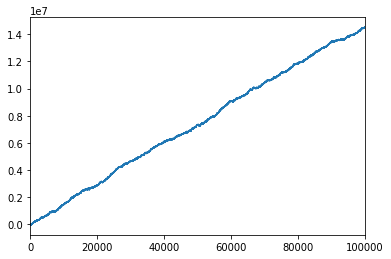

In [472]:
pd.Series(TotalPNL).cumsum().plot()
plt.show()